# An example of template matching with OpenCV

In this notebook we give an example of finding a planar template within an image in a manner which is robust to perspective distortion.

In [15]:
!pip install opencv-contrib-python

^C
Traceback (most recent call last):
  File "/anaconda3/bin/pip", line 7, in <module>
    from pip._internal import main
  File "/anaconda3/lib/python3.6/site-packages/pip/_internal/__init__.py", line 42, in <module>
    from pip._internal import cmdoptions
  File "/anaconda3/lib/python3.6/site-packages/pip/_internal/cmdoptions.py", line 16, in <module>
    from pip._internal.index import (
  File "/anaconda3/lib/python3.6/site-packages/pip/_internal/index.py", line 24, in <module>
    from pip._internal.download import HAS_TLS, is_url, path_to_url, url_to_path
  File "/anaconda3/lib/python3.6/site-packages/pip/_internal/download.py", line 47, in <module>
    from pip._internal.utils.ui import DownloadProgressProvider
  File "/anaconda3/lib/python3.6/site-packages/pip/_internal/utils/ui.py", line 312, in <module>
    class RateLimiter(object):
KeyboardInterrupt


In [16]:
# Enable inline plotting
%matplotlib inline

# Import the libraries we need
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from urllib.request import urlopen
from io import BytesIO
import cv2

# Make the plots look a little nicer
plt.rcParams.update({
    'image.cmap': 'gray',
    'image.interpolation': 'none',
    'figure.figsize': (14, 9)
})

We'll download the image and logo to match from the web:

In [4]:
IMAGE_URL='https://upload.wikimedia.org/wikipedia/commons/9/90/FedEx_Express_Mercedes_Sprinter_Memphis_TN_2012_07_17_017.jpg'
TEMPLATE_URL='http://grouppartners.net/blog/wp-content/uploads/2013/01/fedex-logo.jpg'

Text(0.5,1,'Template')

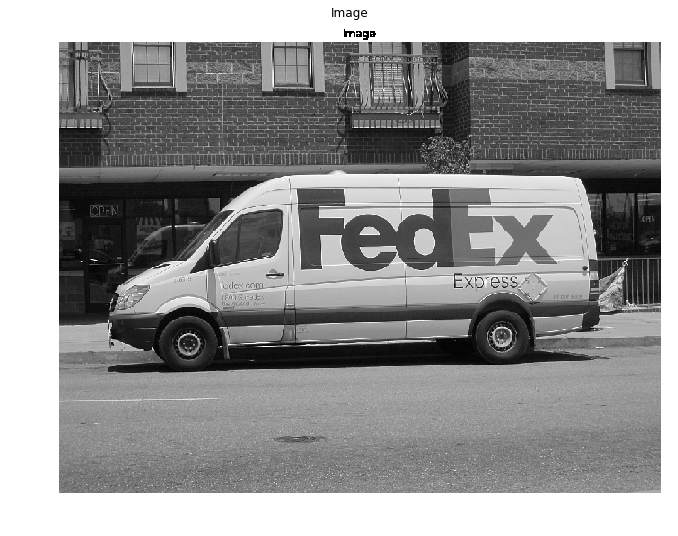

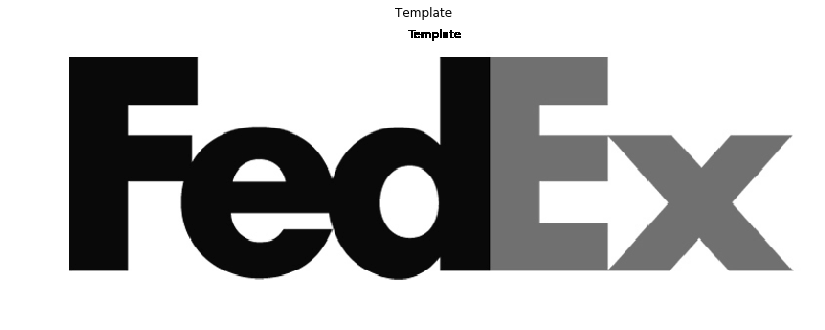

In [17]:
def load_greyscale_image_from_url(url):
    with urlopen(url) as f:
        return np.asarray(Image.open(BytesIO(f.read())).convert('L'))

image = cv2.imread('car.png')
template = cv2.imread('template.png')

plt.figure()
plt.imshow(image)
plt.axis('off')
plt.title('Image')

plt.figure()
plt.imshow(template)
plt.axis('off')
plt.title('Template')

We will use SIFT keypoints and descriptors.

In [18]:
# Create a SIFT detector
detector = cv2.xfeatures2d.SIFT_create()
kps, descs = detector.detectAndCompute(image, mask=None)

# Create a matcher for the image
matcher = cv2.DescriptorMatcher_create('FlannBased')
matcher.add([np.float32(descs)])
matcher.train()

AttributeError: module 'cv2.cv2' has no attribute 'xfeatures2d'

In [5]:
# Detect feature in the template and find a set of good matches
template_kps, template_descs = detector.detectAndCompute(template, mask=None)

matches = matcher.knnMatch(np.float32(template_descs), k=2)
good_matches = [m[0] for m in matches if m[0].distance < 0.7 * m[1].distance]

print('# good matches:', len(good_matches))

# good matches: 30


Show the keypoint matches and, if there are enough, estimate the homography.

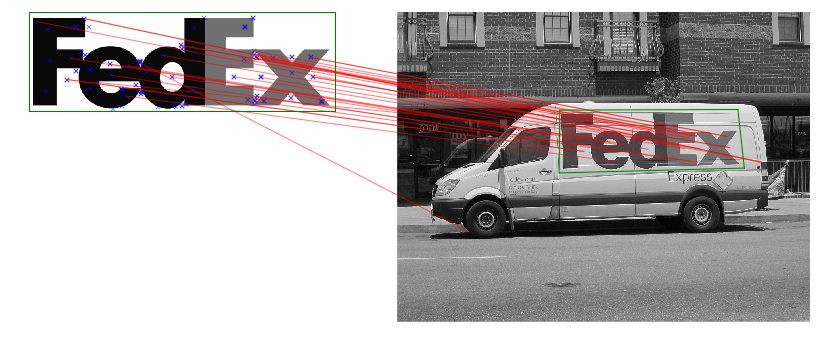

In [6]:
dx = int(template.shape[1] * 1.2)
plt.imshow(template, extent=(0, template.shape[1], template.shape[0], 0))
plt.imshow(image, extent=(dx, dx+image.shape[1], image.shape[0], 0))
plt.axis([0, dx+image.shape[1], image.shape[0], 0])
plt.axis('off')
plt.gca().set_aspect('equal')

#plt.scatter([dx + kp.pt[0] for kp in kps], [kp.pt[1] for kp in kps], marker='x', color='b', alpha=0.5)
plt.scatter([kp.pt[0] for kp in template_kps], [kp.pt[1] for kp in template_kps], marker='x', color='b', alpha=0.5)

ax = plt.gca()
for m in good_matches:
    template_kp, img_kp = template_kps[m.queryIdx], kps[m.trainIdx]
    ax.add_artist(plt.Line2D(
        [template_kp.pt[0], dx + img_kp.pt[0]], [template_kp.pt[1], img_kp.pt[1]],
        color='r', alpha=0.5,
    ))
    
MIN_MATCH_COUNT = 15

if len(good_matches) >= MIN_MATCH_COUNT:
    im_pts = np.float32([kps[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)
    tpl_pts = np.float32([template_kps[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)

    M, mask = cv2.findHomography(tpl_pts, im_pts, cv2.LMEDS)
    matches_mask = mask.ravel().tolist()

    h, w = template.shape
    pts = np.float32([[0,0], [0,h-1], [w-1,h-1], [w-1,0]]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts, M)
    
    ax = plt.gca()
    for idx in range(pts.shape[0]):
        p1, p2 = pts[idx-1, 0, :], pts[idx, 0, :]
        ax.add_artist(plt.Line2D([p1[0], p2[0]], [p1[1], p2[1]], color='g'))
    for idx in range(dst.shape[0]):
        p1, p2 = dst[idx-1, 0, :], dst[idx, 0, :]
        ax.add_artist(plt.Line2D([dx + p1[0], dx + p2[0]], [p1[1], p2[1]], color='g'))